# Module 3 Project


In [128]:
import sqlite3 as sql
import pandas as pd
import numpy as np
import scipy.stats as scs

from statsmodels.stats.power import TTestIndPower
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import preprocessing
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
from scipy import stats
from sklearn import linear_model as lm
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison



In [129]:
conn = sql.Connection("Northwind_small.sqlite")   #Connecting to the data base
c = conn.cursor()

In [130]:
tables = c.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall() #Fetching all the table names
tables = [i[0] for i in tables]

In [131]:
dfa = [] # Loop to put all tables into pandas dataframes
for i in tables:
    table = c.execute('select * from "'+i+'"').fetchall()
    columns = c.execute('PRAGMA table_info("'+i+'")').fetchall()
    df = pd.DataFrame(table, columns=[i[1] for i in columns])
   
    foo = i+"_df"
    exec(foo + " = df") # => TableName_df
    
    dfa.append(foo)
    
print(dfa)

['Employee_df', 'Category_df', 'Customer_df', 'Shipper_df', 'Supplier_df', 'Order_df', 'Product_df', 'OrderDetail_df', 'CustomerCustomerDemo_df', 'CustomerDemographic_df', 'Region_df', 'Territory_df', 'EmployeeTerritory_df']


## Question 2. 
   ##### Does different shipper have different frieght cost ?
    
   Null Hypothesis ($H_0$): There is no significant frieght cost difference from the shippers.

   $$\mu_A = \mu_B = \mu_C$$

   Alternative Hypothesis ($H_1$): There's significant friehgt cost difference from the shipppers.

   $$\mu_A \neq \mu_B \neq \mu_C$$   
   
   First required thing to do is looking in to the data, do some examination.

### EDA

Exploratory Data Analysis comes always first.
Let's connect to the database and see what the enemy looks like.



Quick run-through was performed below.

In [132]:
#Query for loading the data for hypothesis testing number two.

query = """ 
SELECT 
    s.CompanyName, o.Freight
FROM 
    [Shipper] s
    JOIN
    [Order] o
    ON 
    o.ShipVia = s.Id
"""
ship_df = pd.read_sql_query(query, conn) 
fed_df = ship_df.loc[ship_df.CompanyName == 'Federal Shipping']
speed_df = ship_df.loc[ship_df.CompanyName == 'Speedy Express']
united_df = ship_df.loc[ship_df.CompanyName == 'United Package']
print(ship_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 2 columns):
CompanyName    830 non-null object
Freight        830 non-null float64
dtypes: float64(1), object(1)
memory usage: 13.0+ KB
None


In [133]:
print(ship_df.head(10)) #First 10 data from the query

        CompanyName  Freight
0  Federal Shipping    32.38
1    Speedy Express    11.61
2    United Package    65.83
3    Speedy Express    41.34
4    United Package    51.30
5    United Package    58.17
6    United Package    22.98
7  Federal Shipping   148.33
8    United Package    13.97
9  Federal Shipping    81.91


In [134]:
print(ship_df.describe())  #Quick stat info

           Freight
count   830.000000
mean     78.244205
std     116.779294
min       0.020000
25%      13.380000
50%      41.360000
75%      91.430000
max    1007.640000


In [135]:
print(ship_df.groupby('CompanyName').describe()) #Quick stastical data from the each company

                 Freight                                                     \
                   count       mean         std   min    25%     50%    75%   
CompanyName                                                                   
Federal Shipping   255.0  80.441216  119.362844  0.40  12.86  36.710  99.49   
Speedy Express     249.0  65.001325   75.393587  0.12  12.75  40.420  89.90   
United Package     326.0  86.640644  138.219262  0.02  14.04  44.135  91.43   

                           
                      max  
CompanyName                
Federal Shipping  1007.64  
Speedy Express     458.78  
United Package     890.78  


Looks like there're total of three different shipping companies.
The max number of freight count is 326 from United Package, the lowest count is 249 from Speedy Express. The total number of three group was 830.



Let's take a look at the data distribution. Normaly distributed sample is required for most of the hypothesis test. 

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


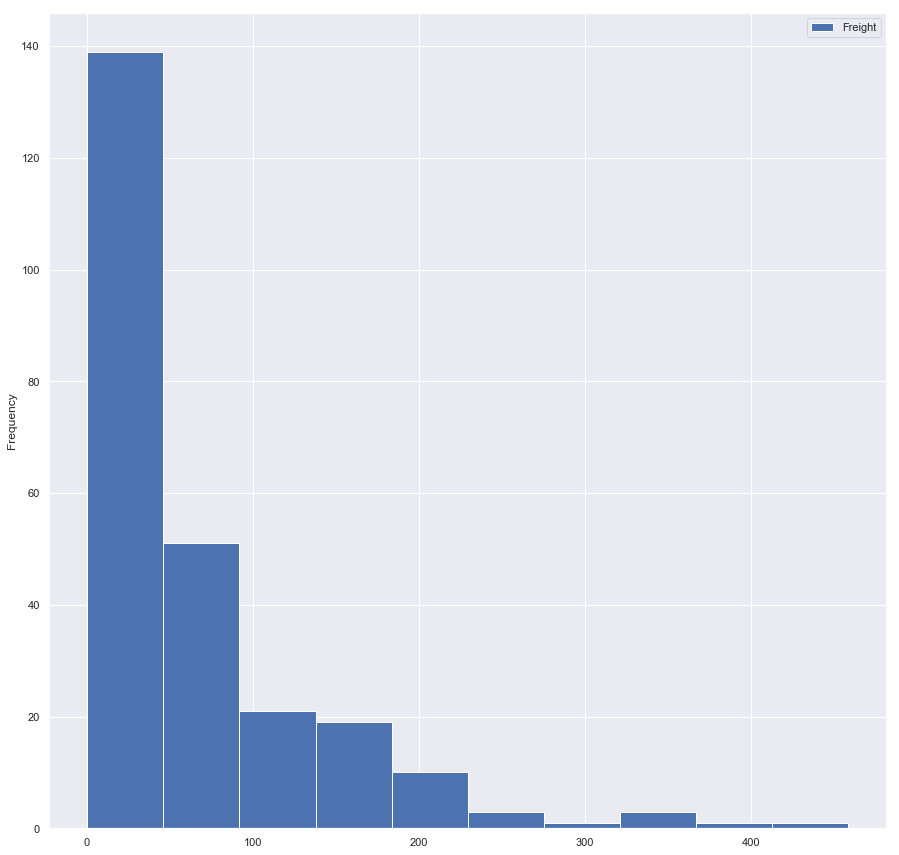

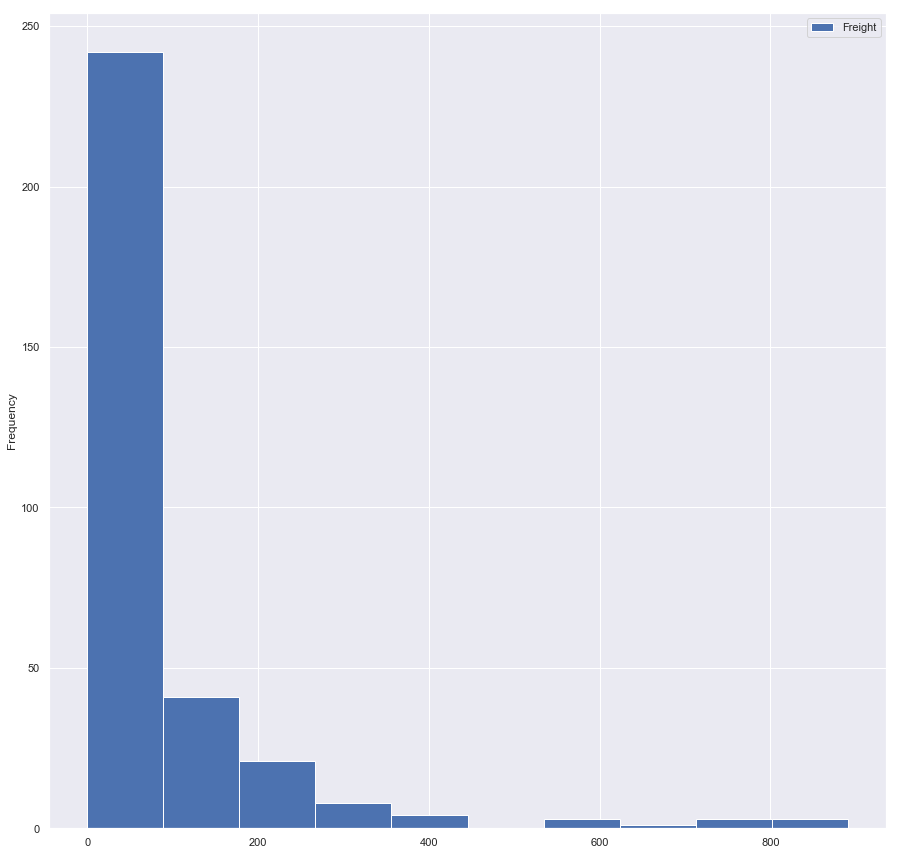

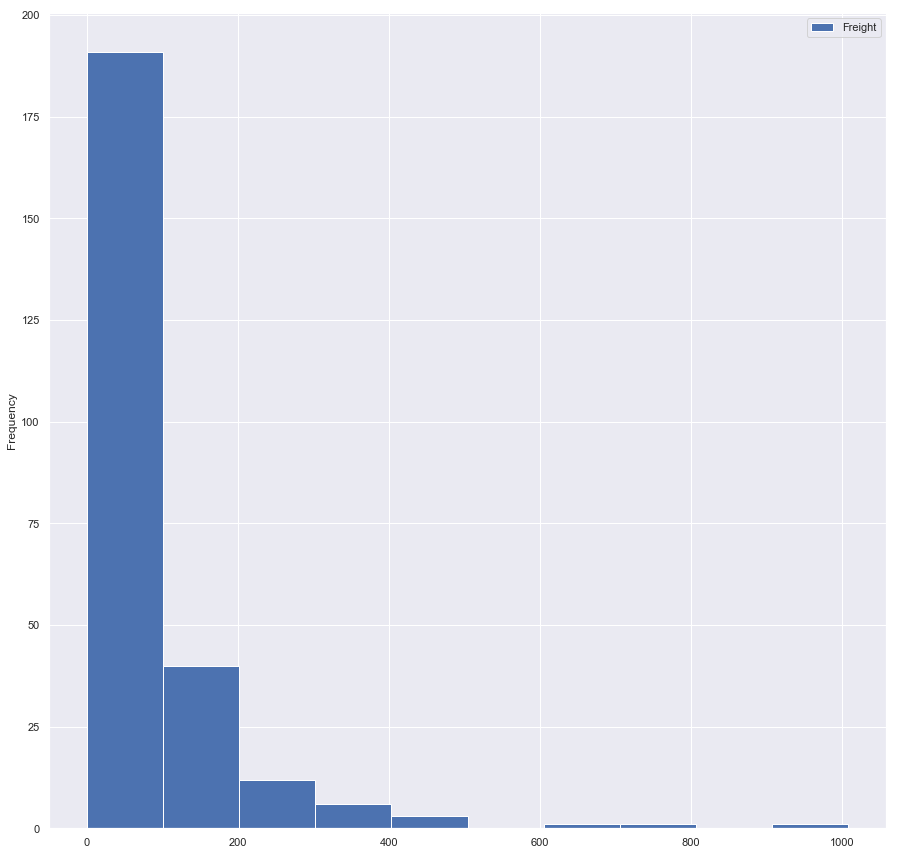

In [136]:
print(speed_df.plot(kind='hist')) # Plotting histograms for each of the shipping companies.
print(united_df.plot(kind='hist'))
print(fed_df.plot(kind='hist'))



C:\Users\Jun\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


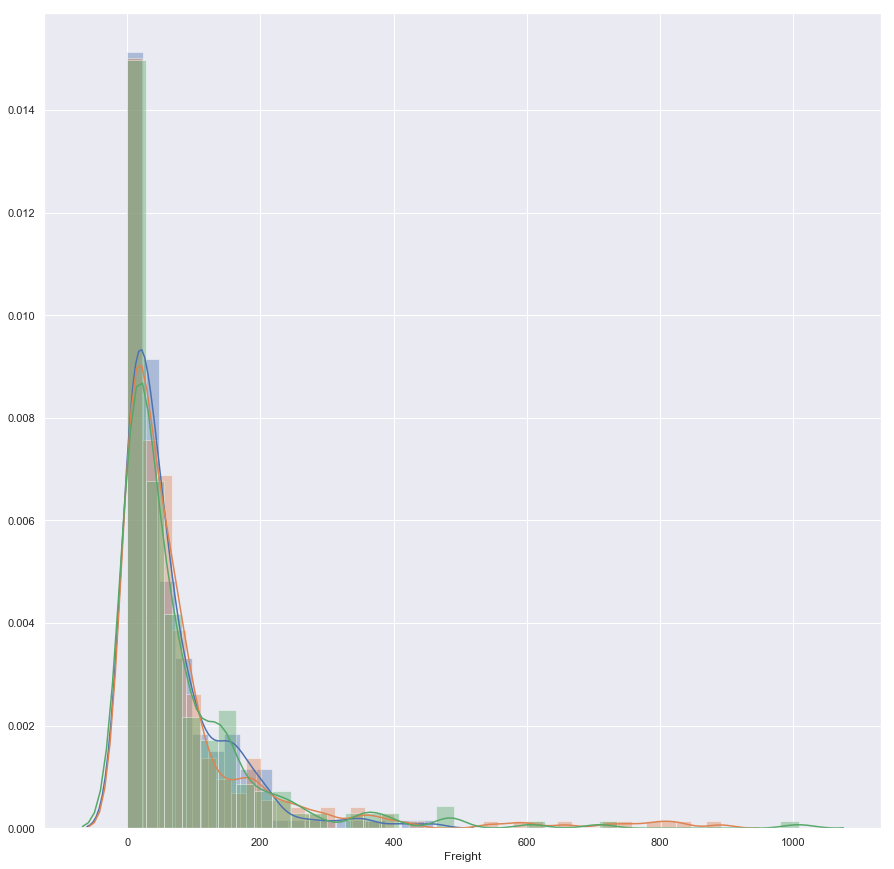

In [137]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(15,15)})
sns.distplot(speed_df.Freight)
sns.distplot(united_df.Freight)
sns.distplot(fed_df.Freight)

Looking at the graphs, samples are left scewed.

For this hypothesis testing, margin of error will be 5%, and the confidence level is 95%.
Popular size and stanrd deviation is already known, so we should be able to calculated required sample size from 4 variables we have.


### Which test to use for hypothesis testing?

Since hypothesis number two has three different groups, and testing if there's any difference between freight cost among them. ANOVA, Analysis of Varaiance might be the right one for this since there're more than two groups. But, there're requirements to meet first in order to use ANOVA. 

#### Assumptions for ANOVA Test
There are three assumptions for ANOVA test. Those are random samples, normal distribution, equal variance.

Let's tackle one at a time to exmaine ANOVA is the right tool.

1. Random sample:

 All the data was independently drawn ones. It's not dependent to each other at all, so It meets the requirements.
 

2. Normal distribution:

 Looking at the graphs above for the examining sample data, it doesn't have normal bell curve for all three. It's right skewed distribution. But, according to the central limit theorem, if the sample sizes are large enough, the distribution of means will follow a Gaussian distribution(normal distribution) even if the population is not Gaussian.Safe sample size to invoking this assumption is kwon as larger than 10 samples in the groups. Since there're way more than 10 samples for each groups, it is safe to invoke this assumption and proceed.
 
 
3. Equal variance:

 To test equal variance, there're many ways to test it, but Levne's test is one of the easiest and well kwon method to test. If the p-value is larger than 0.05, then the variances are not significantly different from each other. Let's run it and see if three gorup has equal variance.

In [139]:
scs.levene(speed_df.Freight, united_df.Freight, fed_df.Freight)

LeveneResult(statistic=2.962264195050304, pvalue=0.0522505977506296)

P value is equal to 0.052. The variance between three groups turned out to be not significantly different.

So, it turns out to be ANOVA is the right tool to use for hypothesis number 2!

### Stastical Power

Right tool for the testing was choosen, but there's still antoher thing to be chosen for before the actual testing. It is the stastical power. It is one of the most importan thing for the hypothesis testing to get a valid result from the test. It shows how likely a test is to distinguish an actual effect from total random chance. For this hypothesis, alpha and  beta will be designated as following, until enough number of sample size is verified later.

$$\alpha = 0.05$$
$$\beta = 0.05$$

Stastical power and confidence level will be both at 95%
In order to verify what sample size is required to have both of the confidence level and stastic power. 

Below is parameters for power analysis.

In [ ]:
# parameters for power analysis
effect = some number 0.154269
alpha = some number
power = some number 0.4
# perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect, power=power, nobs1=None, ratio=1.0, alpha=alpha)
print('Sample Size: %.3f' % result)

Looking at the parameters, effect size needs to be calculated.
Cohen's D is for only two groups. All three combinations will be used and smallest effect size number will be used to verify minimum number of the sample size required for the valid test.

In [141]:
# Function for calculating cohen's D for effect size
def Cohen_d(group1, group2):

    diff = group1.mean() - group2.mean()
    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    d = diff / np.sqrt(pooled_var)
    return abs(d)

In [142]:
print('Speedy Express vs United Package', Cohen_d(speed_df.Freight,united_df.Freight))
print('SPeedy Express vs Federal Shipping', Cohen_d(fed_df.Freight, speed_df.Freight))
print('United Package vs Federal Shipping', Cohen_d(united_df.Freight,fed_df.Freight))

Speedy Express vs United Package 0.18768637021371215
SPeedy Express vs Federal Shipping 0.15426927339532306
United Package vs Federal Shipping 0.047585527662770445


In [143]:
# parameters for power analysis
effect_size = 0.047586
alpha = .2
power = .26
# perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect, power=power, nobs1=None, ratio=1.0, alpha=alpha)
print('Sample Size: %.3f' % result)

Sample Size: 243.536


Playing around with the number for the Power and confidence level, the minimum sample size maximizing the confidence level and the power level was 243. The smallest data sample is 249, Speedy Express and other two sample has larger sample numbers. So this hypothesis testing will have confidence level of 80% and stastical power of 26% 

$$ \alpha = 0.2$$
$$ \beta = 0.76$$

Now, it is time to draw random samples of 249 from the each sample groups and run the ANOVA test.

In [199]:
sample_fed = fed_df.Freight.sample(243)
sample_speed = speed_df.Freight.sample(243)
sample_united = united_df.Freight.sample(243)

In [200]:
F, p = stats.f_oneway(sample_fed, sample_speed, sample_united)
print('F-value = ', F,'P-value = ', p)

F-value =  2.845838563484971 P-value =  0.058733726587711844
